In [1]:
#!fsharp
#r "nuget: Microsoft.ML.ImageAnalytics, 1.5.2"
#r "nuget: Microsoft.ML.Vision, 1.5.2"
#r "nuget: SciSharp.TensorFlow.Redist, 2.3.1"
#r "nuget: SixLabors.ImageSharp, 1.0.2"
#r "nuget: MLOps.NET, 1.3.0"
#r "nuget: MLOps.NET.SQLite, 1.3.0"

Installed package SciSharp.TensorFlow.Redist version 2.3.1

Installed package MLOps.NET version 1.3.0

Installed package SixLabors.ImageSharp version 1.0.2

Installed package MLOps.NET.SQLite version 1.3.0

Installed package Microsoft.ML.Vision version 1.5.2

Installed package Microsoft.ML.ImageAnalytics version 1.5.2

In [1]:
#!fsharp
open System
open System.IO
open Microsoft.ML
open Microsoft.ML.Vision
open Microsoft.ML.Transforms
open Microsoft.ML.Data
open SixLabors.ImageSharp
open SixLabors.ImageSharp.Processing
open Microsoft.DotNet.Interactive.FSharp.FSharpKernelHelpers

In [1]:
#!fsharp
type ImageData =
    { ImagePath: string
      Label: string }

[<CLIMutable>]
type ModelInput =
    { Image: byte[]
      Label: string }

[<CLIMutable>]
type ModelOutput =
    { Image: byte[]
      Label: string
      PredictedLabel: string }

In [1]:
#!fsharp
[<Literal>]
let projectRoot = @"C:\Users\grego\source\repos\IsItKrampus.NET"

let dataDir = Path.Combine(projectRoot, "data")
let prepDir = Path.Combine(dataDir, "prepared")
let workspaceDir = Path.Combine(projectRoot, "workspace")

In [1]:
#!fsharp
let mlContext = MLContext(1)

In [1]:
#!fsharp
let loadImagesFromPreparedDir () =
    File.ReadAllLines (Path.Combine(dataDir, "image_prep.csv"))
    |> Array.skip 1
    |> Array.map (fun line ->
        let parts = line.Split(',')
        (parts.[0], parts.[1], bool.Parse parts.[6]))
    |> Array.filter (fun (_, _, isIncluded) -> isIncluded)
    |> Array.map (fun (fileName, label, _) ->
        { ImagePath = fileName
          Label = label })

In [1]:
#!fsharp
let imageData = mlContext.Data.LoadFromEnumerable(loadImagesFromPreparedDir())
let shuffledData = mlContext.Data.ShuffleRows(imageData)

In [1]:
#!fsharp
let preprocessingPipeline =
    EstimatorChain()
        .Append(mlContext.Transforms.Conversion.MapValueToKey(inputColumnName = "Label",
                                                              outputColumnName = "LabelAsKey"))
        .Append(mlContext.Transforms
            .LoadRawImageBytes(outputColumnName = "Image",
                               imageFolder = prepDir,
                               inputColumnName = "ImagePath"))

In [1]:
#!fsharp
let preProcessedData =
    preprocessingPipeline.Fit(shuffledData)
        .Transform(shuffledData)

In [1]:
#!fsharp
let trainSplit = mlContext.Data.TrainTestSplit(data = preProcessedData, testFraction = 0.3)
// I need a bigger test fraction because my dataset is relatively small
let validationTestSplit = mlContext.Data.TrainTestSplit(trainSplit.TestSet, testFraction = 0.5)

let trainSet = trainSplit.TrainSet;
let validationSet = validationTestSplit.TrainSet
let testSet = validationTestSplit.TestSet

In [1]:
#!fsharp
let imageClassifierOptions =
    ImageClassificationTrainer.Options(FeatureColumnName = "Image",
                                       LabelColumnName = "LabelAsKey",
                                       ValidationSet = validationSet,
                                       Arch = ImageClassificationTrainer.Architecture.InceptionV3,
                                       TestOnTrainSet = false,
                                       ReuseTrainSetBottleneckCachedValues = false,
                                       ReuseValidationSetBottleneckCachedValues = false,
                                       Epoch = 400,
                                       MetricsCallback = (fun metrics -> display $"%A{metrics}" |> ignore),
                                       WorkspacePath = workspaceDir)

In [1]:
#!fsharp
let trainingPipeline =
    EstimatorChain()
        .Append(mlContext.MulticlassClassification.Trainers.ImageClassification(imageClassifierOptions))
        .Append(mlContext.Transforms.Conversion.MapKeyToValue("PredictedLabel", "PredictedLabel"))

In [1]:
#!fsharp
let trainedModel = trainingPipeline.Fit trainSet

Saver not created because there are no variables in the graph to restore


Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   1

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   2

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   3

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   4

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   5

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   6

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   7

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   8

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:   9

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  10

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  11

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  12

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  13

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  14

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  15

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  16

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  17

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  18

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  19

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  20

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  21

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  22

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  23

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  24

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  25

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  26

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  27

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  28

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  29

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  30

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  31

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  32

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  33

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  34

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  35

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  36

Phase: Bottleneck Computation, Dataset used: Validation, Image Index:  37

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   1

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   2

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   3

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   4

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   5

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   6

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   7

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   8

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:   9

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  10

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  11

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  12

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  13

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  14

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  15

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  16

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  17

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  18

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  19

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  20

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  21

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  22

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  23

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  24

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  25

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  26

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  27

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  28

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  29

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  30

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  31

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  32

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  33

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  34

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  35

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  36

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  37

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  38

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  39

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  40

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  41

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  42

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  43

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  44

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  45

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  46

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  47

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  48

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  49

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  50

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  51

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  52

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  53

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  54

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  55

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  56

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  57

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  58

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  59

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  60

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  61

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  62

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  63

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  64

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  65

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  66

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  67

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  68

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  69

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  70

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  71

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  72

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  73

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  74

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  75

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  76

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  77

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  78

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  79

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  80

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  81

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  82

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  83

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  84

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  85

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  86

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  87

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  88

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  89

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  90

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  91

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  92

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  93

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  94

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  95

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  96

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  97

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  98

Phase: Bottleneck Computation, Dataset used:      Train, Image Index:  99

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 100

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 101

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 102

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 103

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 104

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 105

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 106

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 107

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 108

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 109

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 110

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 111

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 112

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 113

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 114

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 115

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 116

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 117

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 118

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 119

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 120

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 121

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 122

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 123

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 124

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 125

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 126

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 127

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 128

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 129

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 130

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 131

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 132

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 133

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 134

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 135

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 136

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 137

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 138

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 139

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 140

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 141

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 142

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 143

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 144

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 145

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 146

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 147

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 148

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 149

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 150

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 151

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 152

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 153

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 154

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 155

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 156

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 157

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 158

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 159

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 160

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 161

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 162

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 163

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 164

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 165

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 166

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 167

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 168

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 169

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 170

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 171

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 172

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 173

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 174

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 175

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 176

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 177

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 178

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 179

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 180

Phase: Bottleneck Computation, Dataset used:      Train, Image Index: 181

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   0, Accuracy:          1, Cross-Entropy: 0,13555433

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   1, Accuracy:          1, Cross-Entropy: 0,09466961

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   2, Accuracy:          1, Cross-Entropy: 0,07911981

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   3, Accuracy:          1, Cross-Entropy: 0,07002884

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   4, Accuracy:          1, Cross-Entropy: 0,06419786

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   5, Accuracy:          1, Cross-Entropy: 0,059857205

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   6, Accuracy:          1, Cross-Entropy: 0,05664449

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   7, Accuracy:          1, Cross-Entropy: 0,054014213

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   8, Accuracy:          1, Cross-Entropy: 0,051930107

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:   9, Accuracy:          1, Cross-Entropy: 0,05013425

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  10, Accuracy:          1, Cross-Entropy: 0,04865344

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  11, Accuracy:          1, Cross-Entropy: 0,047335986

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  12, Accuracy:          1, Cross-Entropy: 0,046220914

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  13, Accuracy:          1, Cross-Entropy: 0,045207027

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  14, Accuracy:          1, Cross-Entropy: 0,044332936

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  15, Accuracy:          1, Cross-Entropy: 0,043525517

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  16, Accuracy:          1, Cross-Entropy: 0,042819917

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  17, Accuracy:          1, Cross-Entropy: 0,04216031

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  18, Accuracy:          1, Cross-Entropy: 0,041577764

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  19, Accuracy:          1, Cross-Entropy: 0,04102814

Phase: Training, Dataset used: Validation, Batch Processed Count:   4, Epoch:  20, Accuracy:          1, Cross-Entropy: 0,04053869

Saver not created because there are no variables in the graph to restore


Restoring parameters from C:\Users\grego\source\repos\IsItKrampus.NET\workspace\custom_retrained_model_based_on_inception_v3.meta


Froze 2 variables.


Converted 2 variables to const ops.


In [1]:
#!fsharp
let predictions = trainedModel.Transform testSet

In [1]:
#!fsharp
let metrics = mlContext.MulticlassClassification.Evaluate(predictions, labelColumnName = "LabelAsKey")

In [1]:
#!fsharp
display $"Micro Accuracy: %f{metrics.MicroAccuracy} Macro Accuracy: %f{metrics.MacroAccuracy} Log Loss: %f{metrics.LogLoss}"

Micro Accuracy: 1.000000 Macro Accuracy: 1.000000 Log Loss: 0.045728

In [1]:
#!fsharp
metrics

LogLoss,LogLossReduction,MacroAccuracy,MicroAccuracy,TopKAccuracy,TopKPredictionCount,PerClassLogLoss,ConfusionMatrix
0.04572824016294066,0.9560232506312076,1,1,0,0,"[ 0.02148157523929432, 0.028247291261625486, 0.08684823600995559 ]",Microsoft.ML.Data.ConfusionMatrix


In [1]:
#!fsharp
open MLOps.NET
open MLOps.NET.SQLite
open MLOps.NET.Storage
open MLOps.NET.Extensions

let dbFolder = Path.Combine(projectRoot, "data", "mlops-data")
let modelRepo = Path.Combine(dbFolder, "model-repo")
let dbFile = Path.Combine(dbFolder, "localmlops.db")

[<Literal>]
let experimentName = "IsItKrampus.NET"

let mlOps =
    MLOpsBuilder()
        .UseSQLite(dbFile)
        .UseLocalFileModelRepository(modelRepo)
        .Build()

In [1]:
#!fsharp
open System.Threading.Tasks

let doSync (task: Task<'a>) =
    task
    |> Async.AwaitTask
    |> Async.RunSynchronously

let doSyncUnit (task: Task) =
    task
    |> Async.AwaitTask
    |> Async.RunSynchronously

In [1]:
#!fsharp
let run =
    mlOps.LifeCycle.CreateRunAsync(experimentName)
    |> doSync

In [1]:
#!fsharp
let modelDir = Path.Combine(projectRoot, "models")
let modelPath = Path.Combine(modelDir, "model.zip")
mlContext.Model.Save(trainedModel, preProcessedData.Schema, modelPath)

In [1]:
#!fsharp
mlOps.Data.LogDataAsync(run.RunId, imageData)
|> doSyncUnit

mlOps.Training.LogHyperParametersAsync(run.RunId, trainedModel)
|> doSyncUnit

mlOps.Evaluation.LogConfusionMatrixAsync(run.RunId, metrics.ConfusionMatrix)
|> doSyncUnit

mlOps.Evaluation.LogMetricsAsync(run.RunId, metrics)
|> doSyncUnit

In [1]:
#!fsharp
let runArtifact =
    mlOps.Model.UploadAsync(run.RunId, Path.Combine(modelPath))
    |> doSync

let registeredModel =
    mlOps.Model.RegisterModel(run.ExperimentId, runArtifact.RunArtifactId, "@GBeyerle")
    |> doSync

In [1]:
#!fsharp
let mutable predictionPipelineSchema : DataViewSchema = null
let loadedModel = mlContext.Model.Load(modelPath, &predictionPipelineSchema)

In [1]:
#!fsharp
let predictionEngine = mlContext.Model.CreatePredictionEngine<ModelInput, ModelOutput>(loadedModel)


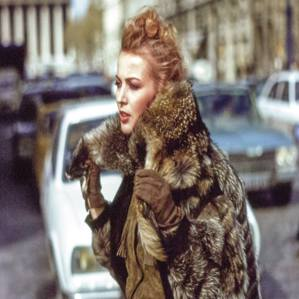

In [1]:
#!fsharp
let getRandom (a: 'a array) =
    let rnd = System.Random()
    let idx = rnd.Next(0, Array.length a - 1)
    a.[idx]

let image =
    loadImagesFromPreparedDir()
    |> getRandom
    |> fun i -> Path.Combine(prepDir, i.ImagePath)
    |> File.ReadAllBytes

let base64 = Convert.ToBase64String image

DisplayFunctions.HTML $"<img src=\"data:image/png;base64,{base64}\"></img>"

In [1]:
#!fsharp
let input : ModelInput =
    { Image = image
      Label = null }

let output = predictionEngine.Predict input

output

Image,Label,PredictedLabel
"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0 ... (17469 more) ]",,Other


In [1]:
#!fsharp
let predictedOutputs = mlContext.Data.CreateEnumerable<ModelOutput>(predictions, reuseRowObject = false)

predictedOutputs

index,Image,Label,PredictedLabel
0,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 1, 0, 96, 0, 96, 0, 0 ... (15369 more) ]",Other,Other
1,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0 ... (26249 more) ]",Santa,Santa
2,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 1, 0, 96, 0, 96, 0, 0 ... (26363 more) ]",Krampus,Krampus
3,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 1, 1, 44, 1, 44, 0, 0 ... (24657 more) ]",Other,Other
4,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0 ... (15327 more) ]",Santa,Santa
5,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0 ... (22257 more) ]",Santa,Santa
6,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 1, 1, 44, 1, 44, 0, 0 ... (18200 more) ]",Other,Other
7,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 1, 0, 96, 0, 96, 0, 0 ... (96533 more) ]",Other,Other
8,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 1, 0, 96, 0, 96, 0, 0 ... (115454 more) ]",Krampus,Krampus
9,"[ 255, 216, 255, 224, 0, 16, 74, 70, 73, 70, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0 ... (14928 more) ]",Santa,Santa
